In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score as get_r2_score, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [3]:
downloaded = drive.CreateFile({'id':'15X31Q-RYIUfEKXkTeszOOfkICqQf8Zj4'}) 
downloaded.GetContentFile('ChicagoCrimeCountMonthly.csv')  
data = pd.read_csv('ChicagoCrimeCountMonthly.csv', error_bad_lines=False)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data["Date"] = data["Date"].dt.strftime("%m/%d/%Y")
data.columns = ['Date', 'Crime Count']

In [4]:
data

,Date,Crime Count
0,01/31/2001,74995
1,02/28/2001,66288
2,03/31/2001,53122
3,04/30/2001,40166
4,05/31/2001,41876
...,...,...
188,09/30/2016,23235
189,10/31/2016,23314
190,11/30/2016,21140
191,12/31/2016,19580


In [5]:
crime_counts = np.asarray(data['Crime Count'].values)
print(len(crime_counts))
dates = np.asarray(data['Date'].values)
print(len(dates))

193
193


In [6]:
def measure_error(actual, predicted):
  rmse = np.sqrt(mean_squared_error(actual, predicted))
  r2 = get_r2_score(actual, predicted)
  return rmse, r2 

In [7]:
def fit_model(X, y, n_steps):
  # # define model
  # model = Sequential()
  # model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
  # model.add(Dense(50, activation='relu'))
  # model.add(Dense(50, activation='relu'))
  # model.add(Dense(1))
  # model.compile(optimizer='adam', loss='mse')
  # # fit model
  # print(model.summary())
  # print(len(X), len(y))
  
  # model.fit(X, y, epochs=1000, verbose=0)

  model = Sequential()
  model.add(Dense(100, activation='relu', input_dim=n_steps))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
# fit model
  model.fit(X, y, epochs=2000, verbose=0)

  print(model.summary())
  print(len(X), len(y))

  model.fit(X, y, epochs=1000, verbose=0)

  return model

In [8]:
def split_sequence(crime_counts, dates, n_steps):
  X, y, X_dates, y_date = list(), list(), list(), list()
  for i in range(len(crime_counts)):
    end_ix = i + n_steps
    if end_ix > len(crime_counts)-1:
      break
    seq_x, seq_y = crime_counts[i : end_ix], crime_counts[end_ix]
    seq_x_dates, seq_y_date = dates[i : end_ix], dates[end_ix]
    X.append(seq_x)
    y.append(seq_y)
    X_dates.append(seq_x_dates)
    y_date.append(seq_y_date)
  return np.array(X), np.array(y), np.array(X_dates), np.array(y_date)

In [9]:
def split_train_test_data(X, y, train_size, test_size):
  return X[0: train_size], X[train_size: train_size + test_size], y[0: train_size], y[train_size: train_size + test_size] 

In [22]:
def evaluation_on__rolling_forecasting(crime_counts, dates, train_size, test_size):
  
  # defines how many time we want to insert into model to predict next timing
  n_steps = 40
  # split into samples
  X, y, X_dates, y_date = split_sequence(crime_counts, dates, n_steps)
  record_size = len(X)

  # reshape from [samples, timesteps] into [samples, timesteps, features]

  # print(X.shape[0], X.shape[1])
  X = X.reshape((X.shape[0], X.shape[1]))
  X_dates = X_dates.reshape((X_dates.shape[0], X_dates.shape[1]))
  rmse_scores = []
  r2_scores = []
  predictions = []
  y_test = []
  y_test_date = []
  model = None
  print("train_size", train_size, "test_size", test_size, "record_size", record_size)
  for i in range(train_size, record_size - test_size):
    y_test = []
    y_test_date = []
    X_train, X_test, y_train, y_test= split_train_test_data(X , y, i, test_size)
    X_train_dates, X_test_dates, y_train_date, y_test_date = split_train_test_data(X_dates , y_date, i, test_size)

    model = fit_model(X_train, y_train, n_steps)
    print("Done Training The Data")

    predictions = []
    for i in range(0, len(X_test)):
      x_input = np.array(X_test[i])
      x_input = x_input.reshape((1, n_steps))
      yhat = model.predict(x_input, verbose=0)
      # print('Date', y_test_date[i])
      # print("Time Series Values", X_test[i])
      print("Predicted Crime Count", yhat[0][0], "Real Crime Count", y_test[i])
      predictions.append(yhat[0][0])
    print("Done Predicting The Data")
    rmse, r2 = measure_error(y_test, predictions)
    print(' RMSE: %.3f \t R2 score: %.3f' % (rmse, r2))
    rmse_scores.append(rmse)
    r2_scores.append(r2)
  return rmse_scores, r2_scores, model, predictions, y_test, y_test_date

In [30]:
def summarize(rmse_scores, r2_scores):
    rmse_scores = [i for i in rmse_scores]
    r2_scores = [i for i in r2_scores]
    rmse_mean, rmse_std = np.mean(rmse_scores), np.std(rmse_scores)
    r2_mean, r2_std = np.mean(r2_scores), np.std(r2_scores)
    print('RMSE: %.3f (+/- %.3f)' % (rmse_mean, rmse_std))
    print('R2: %.3f (+/- %.3f)' % (r2_mean, r2_std))
    plt.boxplot(rmse_scores)
    plt.show()
    plt.boxplot(r2_scores)
    plt.show()

In [24]:
train_size=130
test_size = 12
rmse_scores, r2_scores, model, predictions, y_test, y_test_date = evaluation_on__rolling_forecasting(crime_counts, dates, train_size, test_size)

train_size 130 test_size 12 record_size 153
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               4100      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 4,201
Trainable params: 4,201
Non-trainable params: 0
_________________________________________________________________
None
130 130
Done Training The Data
Predicted Crime Count 19763.188 Real Crime Count 21560
Predicted Crime Count 21993.453 Real Crime Count 21610
Predicted Crime Count 22981.979 Real Crime Count 23570
Predicted Crime Count 24580.084 Real Crime Count 23059
Predicted Crime Count 24506.217 Real Crime Count 24101
Predicted Crime Count 23981.963 Real Crime Count 24685
Predicted Crime Count 23089.5 Real Crime Count 22996
Predicted Crime Count 23157.691 Real Crime Count 2

In [25]:
model.save('MLP_Univariate_Monthly.h5')

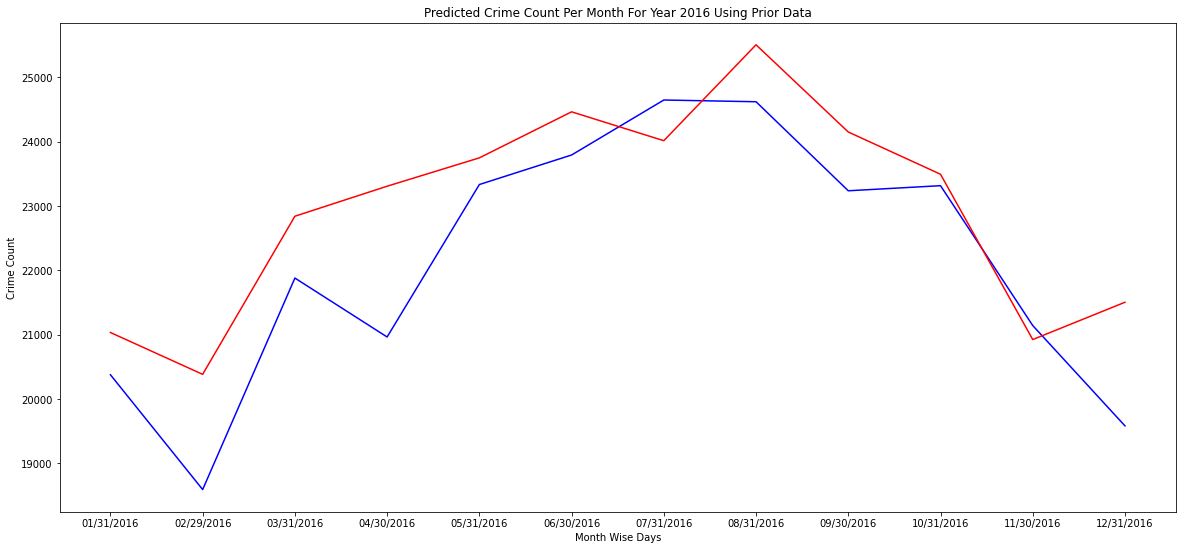

In [26]:
plt.figure(figsize=(20, 9))
plt.title('Predicted Crime Count Per Month For Year 2016 Using Prior Data')
plt.plot(y_test_date, y_test, color = 'blue')
plt.plot(y_test_date, predictions, color= 'red')
plt.ylabel('Crime Count')
plt.xlabel('Month Wise Days')
plt.show()

In [27]:
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

RMSE: 1064.228 (+/- 201.828)
R2: 0.625 (+/- 0.163)


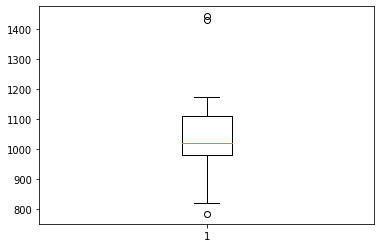

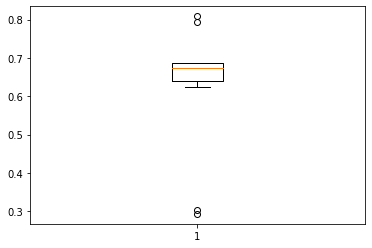

In [31]:
summarize(rmse_scores, r2_scores)